<h1 align='center'>Machine Learning Lab</h1>
<h3 align='center'>Lab 09</h3>

### Importing Packages

In [295]:
import pandas as pd                          #Importing Pandas
import numpy as np                           #Importing Numpy
import matplotlib.pyplot as plt              #Importing Matplotlib
from sklearn.datasets import make_moons      #Importing Moon Dataset

### Exercise 1: Implement Decision Tree

#### Read and split data into three parts train,validation and test (70%, 15% and 15% respectively).

##### Reading the Dataset using Pandas

In [296]:
#Dataset Path
iris_dataset_path = 'Datasets/Iris/iris.data'

In [297]:
#Reading the dataset using pandas CSV function
iris = pd.read_csv(iris_dataset_path, header=None, names=['sepal_length','sepal_width','petal_length','petal_width','class'])

#Storing the header values of the dataset for further use
iris_headers = ['sepal_length','sepal_width','petal_length','petal_width','class']

#Displaying initial Dataset values
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


##### Function to split the Dataset into Train, Validation and Test based on Respective Sizes

In [298]:
def split_dataset(dataset, train_size = 0.7, validation_size = 0.15, test_size = 0.15):
    total_rows = len(dataset)
    dataset = dataset.sample(frac = 1).reset_index(drop=True)
    train_set = dataset.sample(frac = train_size)
    dataset = dataset.drop(train_set.index)
    
    validation_set = dataset[:int(validation_size * total_rows)]
    dataset = dataset.drop(validation_set.index)
    test_set = dataset.copy()
    
    train_set = train_set.to_numpy()
    validation_set = validation_set.to_numpy()
    test_set = test_set.to_numpy()
    
    return train_set, validation_set, test_set

##### Splitting the Iris Dataset using given Set Sizes

In [299]:
iris_train, iris_validation, iris_test = split_dataset(iris)

#### Desigining different parts of Decision Tree

##### Class to represent the condition inside each node in a decision tree

In [300]:
class Question:
    #Initializer/Constructor Function
    def __init__(self, column_name, column, value):
        #Feature Name
        self.column_name = column_name
        
        #Feature Column Index
        self.column = column
        
        #Feature Value
        self.feature_value = value
        
        #Is the feature value numeric or Categorical
        self.feature_numeric = isinstance(self.feature_value, int) or isinstance(self.feature_value, float)
    
    #Function to evaluate an instance on the current condition
    def evaluate(self, row):
        #Extracting the value at column of given instance
        value = row[self.column]
        
        #If the value is numerical than check for less than equal to condition
        if isinstance(value, int) or isinstance(value, float):
            return value <= self.feature_value
        
        #If the value is categorical than check for equals condition
        return value == self.feature_value
    
    #Function to split the dataset into left dataset and right dataset based on the current condition
    def apply_split(self, dataset):
        #List to contain the left and right dataset
        left_partition, right_partition = [], []
        
        #Iterating through all instances and evaluating the condition
        for row in dataset:
            #If true, then appending that instance into left dataset
            if self.evaluate(row):
                left_partition.append(row)
            #If False, then appending that instance into right dataset
            else:
                right_partition.append(row)
        
        #Returning the Left and Right Datasets
        return np.array(left_partition), np.array(right_partition)
    
    #Function to print the condition in a formatted way
    def to_string(self):
        #If feature is numeric than print <= else ==
        check_condition = '<=' if self.feature_numeric else '=='
        
        #Returning the formatted condition String
        return 'check for {} {} {}'.format(self.column_name, check_condition, self.feature_value)

##### Function to Return the Dominant/Most occuring Class in the Dataset

In [301]:
def dominant_class(dataset, target_column):
    #Extracting only the class column from the dataset
    target_values = dataset[:,target_column]
    
    #Extracting the unique classes and their counts
    unique_values, counts = np.unique(target_values, return_counts=True)
    dominant_class = unique_values[np.argmax(counts)]

    #Returning the unique classes and their counts
    return (target_values == dominant_class).sum(), dominant_class

##### Function to calculate the Misclassification Rate on a Node/Condition

In [302]:
def MCR(dataset, target_column, question):
    #Splitting the dataset into left and right dataset based on the condition of the node
    left_data, right_data = question.apply_split(dataset)
    
    #If any of the left/right dataset is empty then return the highest MCR which is 1
    if len(left_data) == 0 or len(right_data) == 0:
        return 1
    
    #Extracting the dominant class and its count from the left dataset
    left_dominant_count, left_dominant_class = dominant_class(left_data, target_column)
    
    #Extracting the dominant class and its count from the Right dataset
    right_dominant_count, right_dominant_class = dominant_class(right_data, target_column)
    
    #Returning the MCR = ((|LD| - |LD_dominant_class_count|) + (|RD| - |RD_dominant_class_count|)) / |D|
    return ((len(left_data) - left_dominant_count) + (len(right_data) - right_dominant_count)) / len(dataset)

##### Function to calculate the Cross entropy of the Dataset

In [303]:
def cross_entropy(dataset, target_column):
    #Initializing the entropy to 0
    entropy = 0
    
    #Extracting the unique classes and its count from the class column
    unique_values, count= np.unique(dataset[:,target_column], return_counts=True)
    
    #Iterating over all unique classes
    for index, unique_val in enumerate(unique_values):
        #Calculating Pt = |unique_class| / |D|
        pt = count[index] / len(dataset)
        
        #Shanon Entropy = Summation(Pt * log(Pt))
        entropy += (pt * np.log2(pt))
        
    #Returning the negative of entropy
    return -1 * entropy

##### Function to calculate the Information Gain

In [304]:
def information_gain(dataset, left_dataset, right_dataset, target_column):
    #Calculating the Cross Entropy of the whole Dataset
    h_d = cross_entropy(dataset, target_column)
    
    #Calculating the Weighted entropy of the Left Dataset
    left_hd = (len(left_dataset)/len(dataset)) * cross_entropy(left_dataset, target_column)
    
    #Calculating the Weighted entropy of the Right Dataset
    right_hd = (len(right_dataset)/len(dataset)) * cross_entropy(right_dataset, target_column)
    
    #Returning the Information Gain = H(D) - (W_H(LD) + W_H(RD))
    return h_d - (left_hd + right_hd)

##### Function to calculate the average values between two consecutive numbers in the column

In [305]:
def numerical_splitting_average(values):
    #Initializing the list
    V = []
    
    #Iterating through each values in pair
    for i in range(len(values) - 1):
        #Calculating the average between two consecutive numbers
        V.append((values[i] + values[i+1])/2)
        
    #Returning the calculated List V
    return V

##### Function to find the Best split based on MCR value

In [306]:
def best_fit_mcr(dataset, headers, target_column):
    #Initializing the best MCR to 1 and best Condition to None
    best_mcr = 1
    best_question = None
    
    #Iterating through all feature columns
    for i in range(len(dataset[0])):
        
        #We have to skip the class column
        if i == target_column:
            continue
        
        #Extracting the unique values from the selected column
        unique_values = np.unique(dataset[:,i])
        
        #If the column values are numeric than calculating the list containing the average values between two consecutive numbers
        if isinstance(unique_values[0], int) or isinstance(unique_values[0], float):
            unique_values = numerical_splitting_average(unique_values)
        
        #Iterating through all unique values
        for unique_val in unique_values:
            
            #Creating a condition with selected feature and unique value
            question = Question(headers[i], i, unique_val)
            
            #Calculating the MCR value for that condition
            mcr = MCR(dataset, target_column, question)
            
            #If we find a better MCR then swapping it with the previous best
            if mcr <= best_mcr:
                best_mcr = mcr
                best_question = question
    
    #Returning the Best MCR and Best Condition
    return best_mcr, best_question

##### Function to find the Best split based on Information Gain value

In [307]:
def best_fit_gain(dataset, headers, target_column):
    #Initializing the best Information Gain to 0 and best Condition to None
    best_gain = 0
    best_question = None
    
    #Iterating through all feature columns
    for i in range(len(dataset[0])):
        #We have to skip the class column
        if i == target_column:
            continue
        
        #Extracting the unique values from the selected column
        unique_values = np.unique(dataset[:,i])
        
        #If the column values are numeric than calculating the list containing the average values between two consecutive numbers
        if isinstance(unique_values[0], int) or isinstance(unique_values[0], float):
            unique_values = numerical_splitting_average(unique_values)
        
        #Iterating through all unique values
        for unique_val in unique_values:
            
            #Creating a condition with selected feature and unique value
            question = Question(headers[i], i, unique_val)
            
            #Calculating the Information Gain value for that condition
            left_data , right_data = question.apply_split(dataset)
            gain = information_gain(dataset, left_data, right_data, target_column)
            
            #If we find a better Information Gain then swapping it with the previous best
            if gain >= best_gain:
                best_gain = gain
                best_question = question
    
    #Returning the Best Information Gain and Best Condition          
    return best_gain, best_question

##### Class to Represent a Node in the Tree

In [308]:
class Node:
    #Initializer/Constructor Function
    def __init__(self, question, left_node, right_node, is_leaf, leaf_class):
        #Condition of the Node
        self.question = question
        
        #Left Child Node
        self.left_node = left_node
        
        #Right Child Node
        self.right_node = right_node
        
        #If the Node is a Leaf Node
        self.is_leaf = is_leaf
        
        #If it is Leaf Node then its output value
        self.leaf_class = leaf_class

###### Function to Learn a Decision Tree from the Dataset

In [361]:
def learn_decision_tree(dataset, headers, target_column, evaluation_metric = 'mcr', max_depth = 2):
    
    #Calculating the Best Condition based on Either MCR or Information Gain
    eval_val , question = best_fit_mcr(dataset, headers, target_column) if evaluation_metric == 'mcr' else best_fit_gain(dataset, headers, target_column)
    
    #At each decision step (or split) presenting the probability of each class using Bar Plot
    unique_values, counts = np.unique(dataset[:,target_column], return_counts=True)
    plt.bar(unique_values, counts)
    plt.title('Probabilities of each class at Level: {}'.format(max_depth))
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.show()
    
    if max_depth == 0:
        #Extracting the Dominant Class
        unique_values, counts = np.unique(dataset[:,target_column], return_counts=True)
        dominant_class = unique_values[np.argmax(counts)]
        
        #Returning the Node
        return Node(question, None, None, True, dominant_class)
    
    #If MCR is 1 or Information Gain is 0 or the Question is Null, then it is Leaf node
    if (evaluation_metric == 'mcr' and eval_val == 1) or (evaluation_metric == 'gain' and eval_val == 0) or question == None:
        #Extracting the Dominant Class
        unique_values, counts = np.unique(dataset[:,target_column], return_counts=True)
        dominant_class = unique_values[np.argmax(counts)]
        
        #Returning the Leaf Node
        return Node(question, None, None, True, dominant_class)
    
    #Split the Data into Left and Right Dataset based on Best Condition
    left_data, right_data = question.apply_split(dataset)
    
    #Creating a Left Child Node using Recursive call
    left_node = learn_decision_tree(left_data, headers, target_column, evaluation_metric, max_depth - 1)
    
    #Creating a Right Child Node using Recursive call
    right_node = learn_decision_tree(right_data, headers, target_column, evaluation_metric, max_depth - 1)
    
    #Returning the Node which is not Leaf and contains Left and Right Nodes
    return Node(question, left_node, right_node, False, '')

##### Function to Print the Tree

In [428]:
def print_tree(root, spaces = ''):
    #The the node is Leaf node, than printing its predicted class with spaces indicating depth
    if root.is_leaf:
        print(spaces + 'Leaf Node: ' + str(root.leaf_class))
        return
    
    #Printing the Node Condition
    print(spaces + root.question.to_string())
    
    #Printing the Left Node if the Condition is True
    print(spaces + 'True: ')
    print_tree(root.left_node, spaces + '  ')
    
    #Printing the Right Node if the Condition is False
    print(spaces + 'False: ')
    print_tree(root.right_node, spaces + '  ')

##### Function to Predict the Class of the Instance Row using Decision Tree

In [363]:
def predict_class(tree , row):
    #If the Node is leaf, then returning the leaf class
    if tree.is_leaf:
        return tree.leaf_class
    
    #If the Node condition is True, then predicting the class with the left Node
    if tree.question.evaluate(row):
        return predict_class(tree.left_node, row)
    #If the Node condition is False, then predicting the class with the Right Node
    else:
        return predict_class(tree.right_node, row)

##### Function to Predict the Classes of the entire Dataset using Decision Tree

In [364]:
def predict_classes(tree, dataset):
    #Initializing the empty list for classes
    predicted_classes = []
    
    #Iterating through all the rows in the dataset
    for row in dataset:
        #Appending the predicted class to the list
        predict_classes.append(predict_class(tree, row))
    
    #Returning the Predicted Class list
    return predicted_classes

##### Function the Calculate the Accuracy of the Decision Tree

In [365]:
def accuracy(tree, dataset, target_column):
    #Initializing the Correct prediction to 0
    correct = 0
    
    #Iterating through all instances
    for row in dataset:
        #Checking if the actual class is equal to the predicted class
        if row[target_column] == predict_class(tree, row):
            correct += 1
            
    #Returning the Accuracy = correct Result / Total Rows
    return correct/len(dataset)

#### Part A: Basic working with MCR

##### Defining an appropriate stopping criteria i.e. max depth

In [366]:
max_depth_list = [1,2,3,4,5]

##### Applying Grid Search on Max-Depth, Printing the Resultant Tree and Displaying the Accuarcy and Cross Entropy Loss

--------------------------------------------------------------

Learning Decision Tree with Misclassification Rate and Max Depth: 1



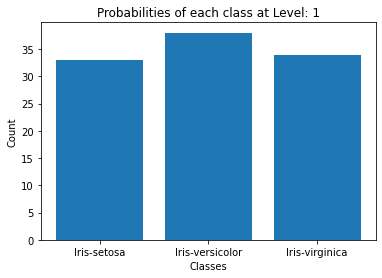

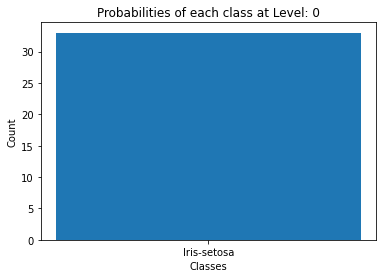

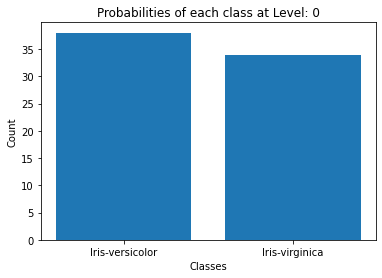

Printing the Tree using a breath first tree traversal:

check for petal_width <= 0.75
True: 
  Leaf Node: Iris-setosa
False: 
  Leaf Node: Iris-versicolor

Accuracy: 0.6363636363636364

Cross Entropy Loss: 0.45198512374305727

--------------------------------------------------------------

Learning Decision Tree with Misclassification Rate and Max Depth: 2



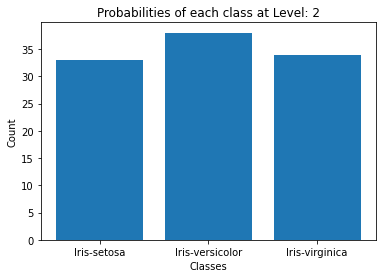

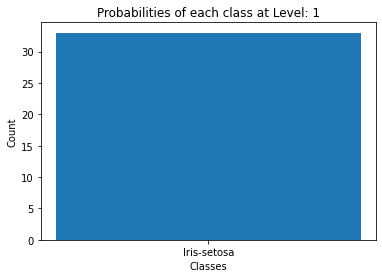

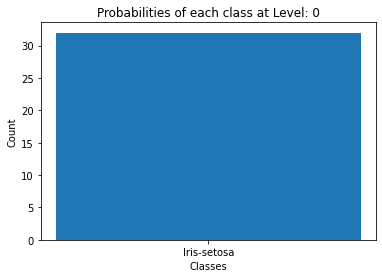

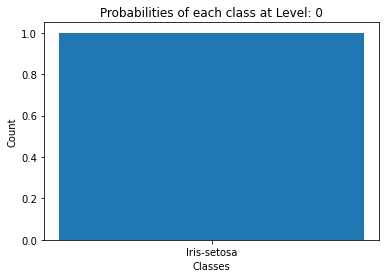

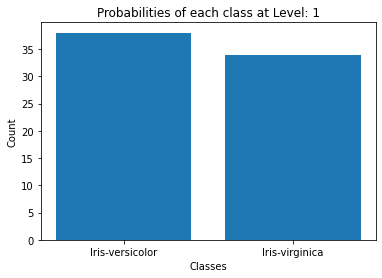

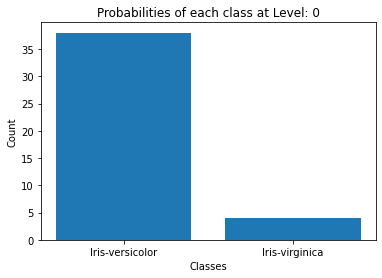

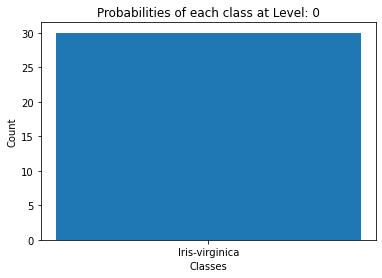

Printing the Tree using a breath first tree traversal:

check for petal_width <= 0.75
True: 
  check for petal_width <= 0.45
  True: 
    Leaf Node: Iris-setosa
  False: 
    Leaf Node: Iris-setosa
False: 
  check for petal_width <= 1.75
  True: 
    Leaf Node: Iris-versicolor
  False: 
    Leaf Node: Iris-virginica

Accuracy: 0.9545454545454546

Cross Entropy Loss: 0.04652001563489282

--------------------------------------------------------------

Learning Decision Tree with Misclassification Rate and Max Depth: 3



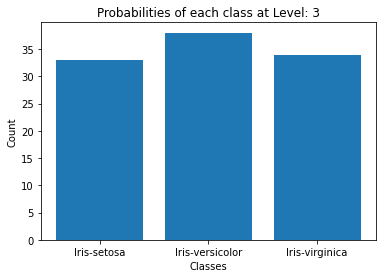

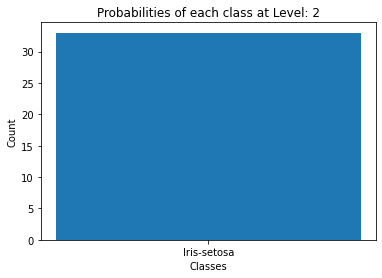

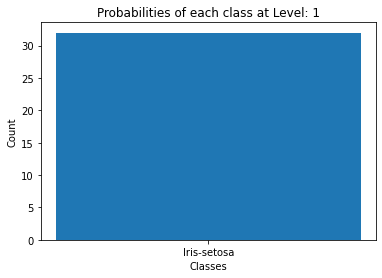

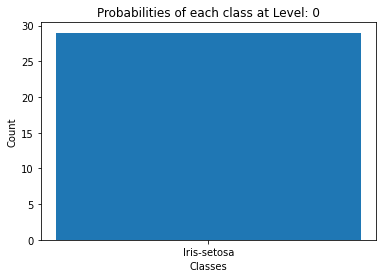

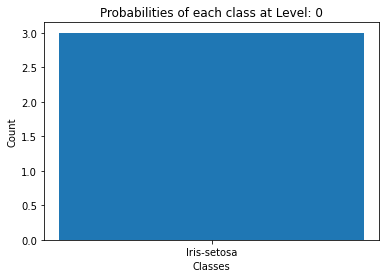

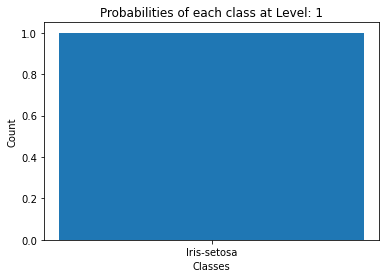

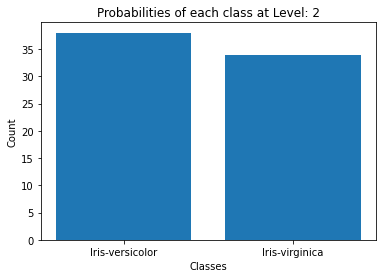

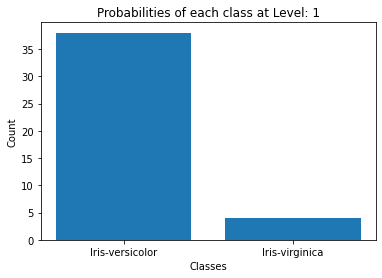

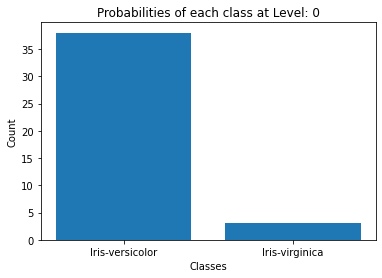

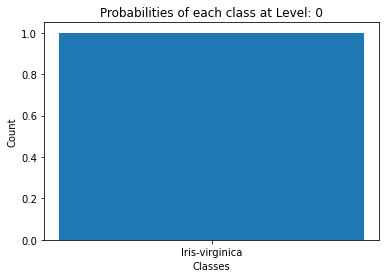

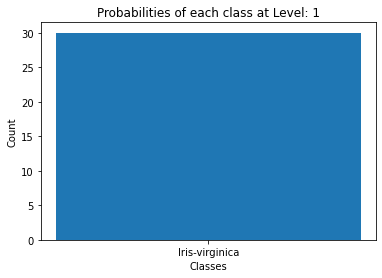

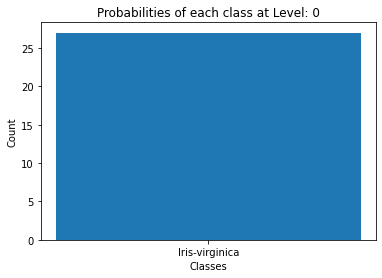

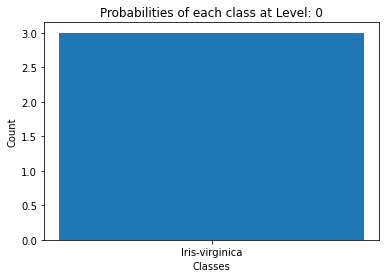

Printing the Tree using a breath first tree traversal:

check for petal_width <= 0.75
True: 
  check for petal_width <= 0.45
  True: 
    check for petal_width <= 0.35
    True: 
      Leaf Node: Iris-setosa
    False: 
      Leaf Node: Iris-setosa
  False: 
    Leaf Node: Iris-setosa
False: 
  check for petal_width <= 1.75
  True: 
    check for petal_length <= 5.35
    True: 
      Leaf Node: Iris-versicolor
    False: 
      Leaf Node: Iris-virginica
  False: 
    check for petal_width <= 2.45
    True: 
      Leaf Node: Iris-virginica
    False: 
      Leaf Node: Iris-virginica

Accuracy: 1.0

Cross Entropy Loss: -0.0

--------------------------------------------------------------

Learning Decision Tree with Misclassification Rate and Max Depth: 4



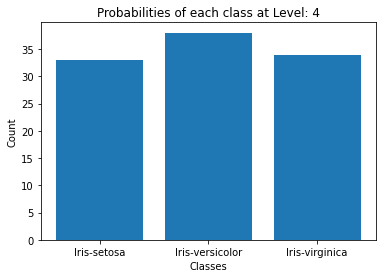

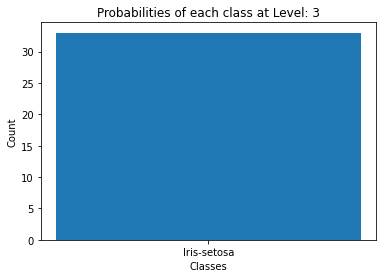

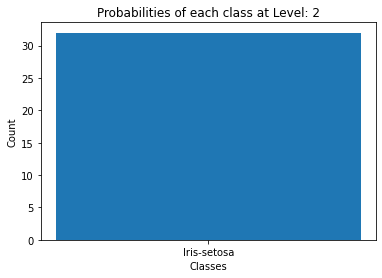

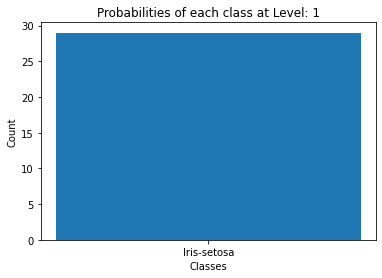

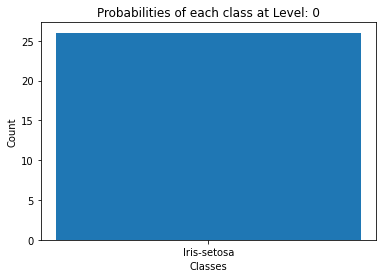

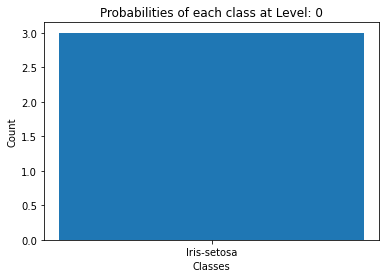

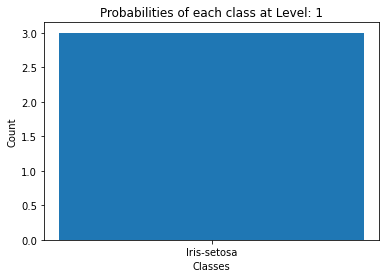

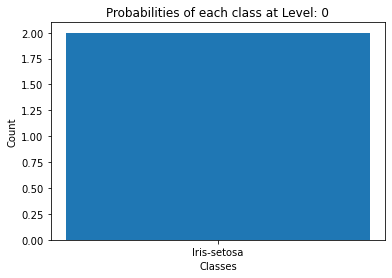

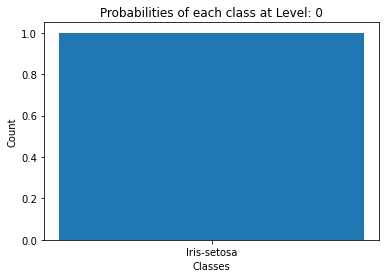

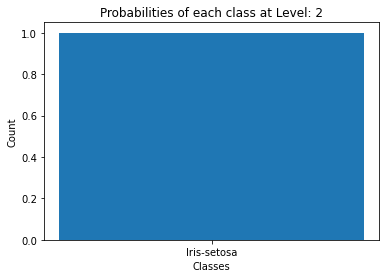

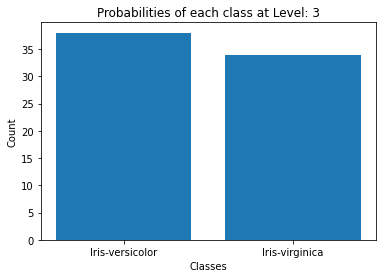

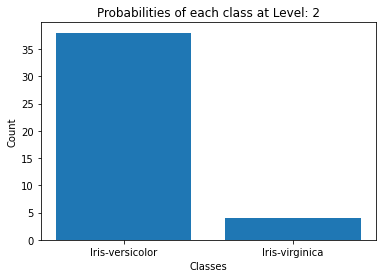

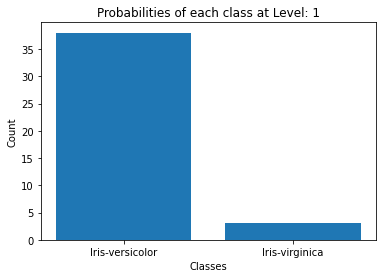

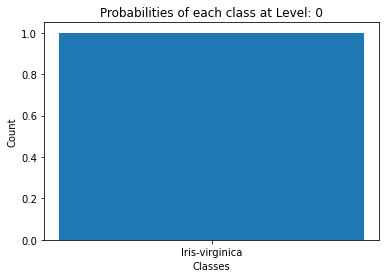

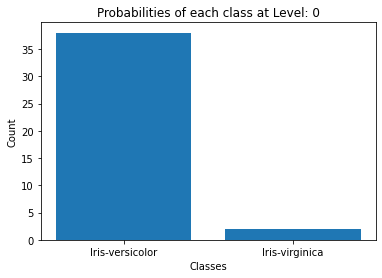

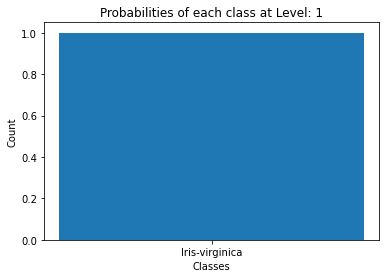

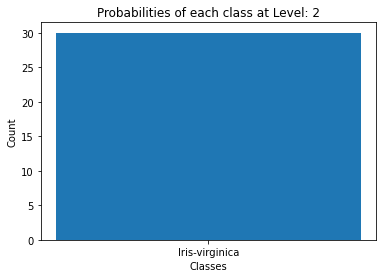

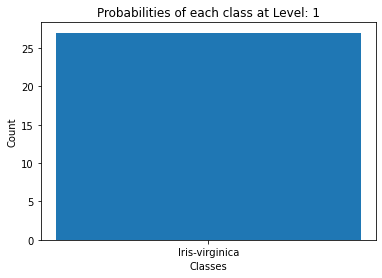

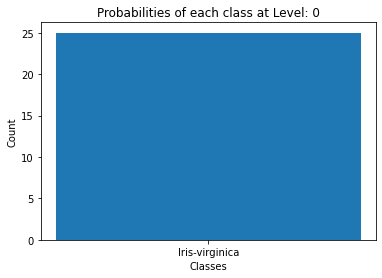

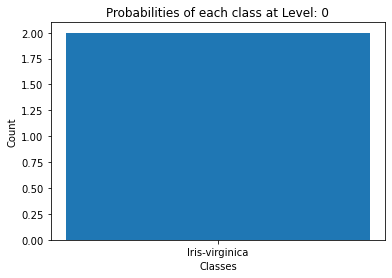

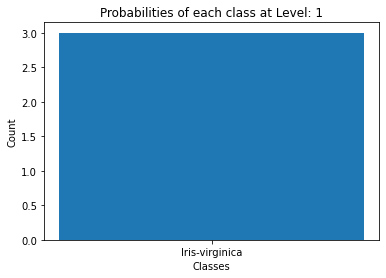

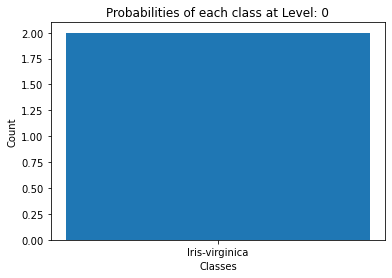

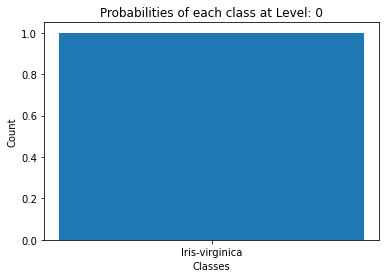

Printing the Tree using a breath first tree traversal:

check for petal_width <= 0.75
True: 
  check for petal_width <= 0.45
  True: 
    check for petal_width <= 0.35
    True: 
      check for petal_width <= 0.25
      True: 
        Leaf Node: Iris-setosa
      False: 
        Leaf Node: Iris-setosa
    False: 
      check for petal_length <= 1.65
      True: 
        Leaf Node: Iris-setosa
      False: 
        Leaf Node: Iris-setosa
  False: 
    Leaf Node: Iris-setosa
False: 
  check for petal_width <= 1.75
  True: 
    check for petal_length <= 5.35
    True: 
      check for sepal_length <= 4.95
      True: 
        Leaf Node: Iris-virginica
      False: 
        Leaf Node: Iris-versicolor
    False: 
      Leaf Node: Iris-virginica
  False: 
    check for petal_width <= 2.45
    True: 
      check for petal_width <= 2.3499999999999996
      True: 
        Leaf Node: Iris-virginica
      False: 
        Leaf Node: Iris-virginica
    False: 
      check for petal_length <= 6.05


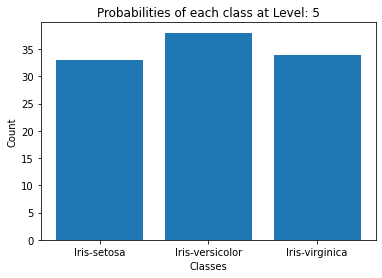

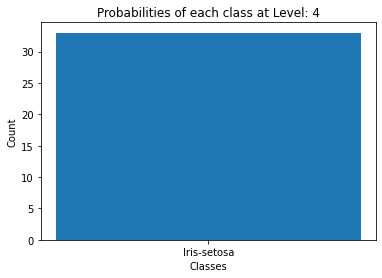

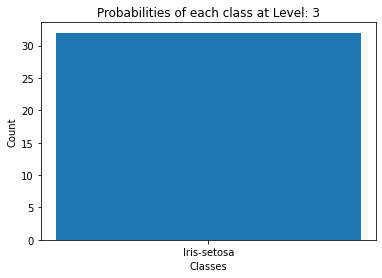

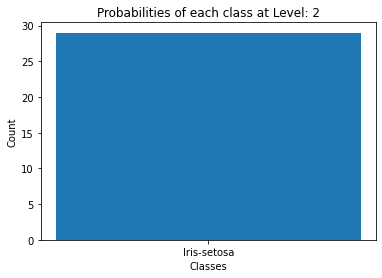

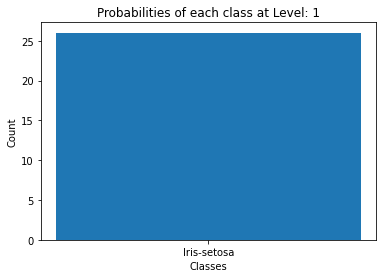

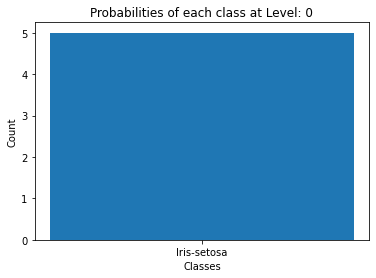

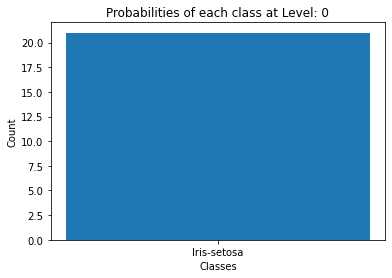

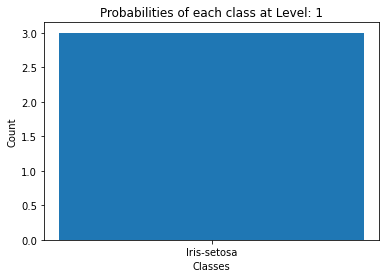

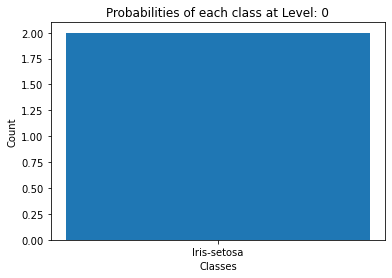

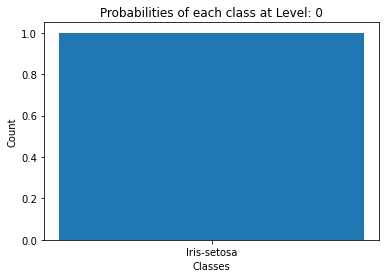

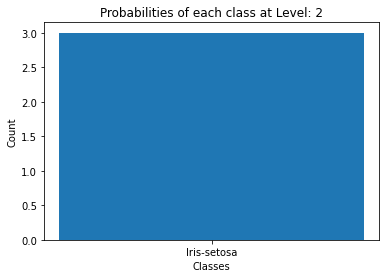

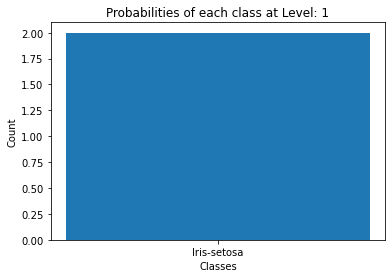

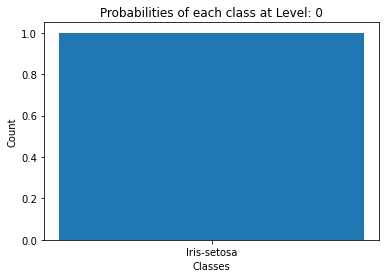

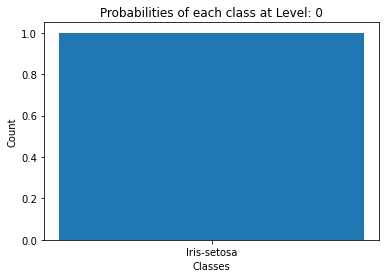

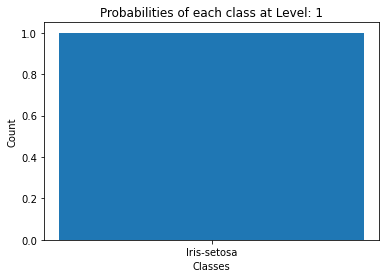

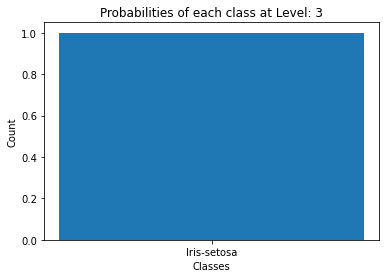

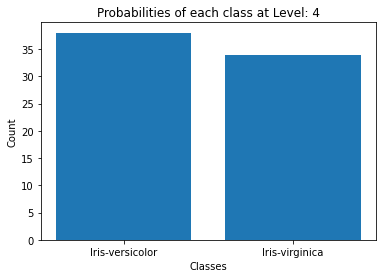

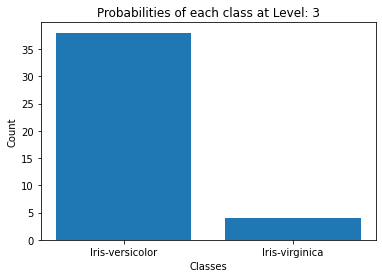

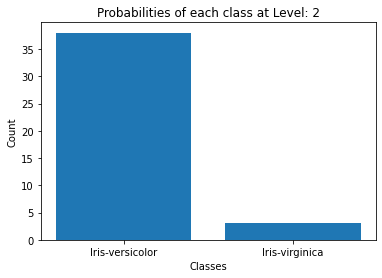

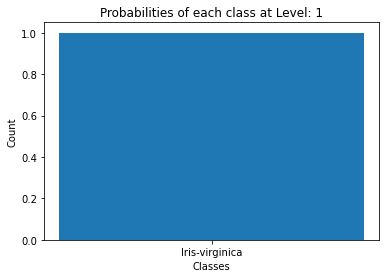

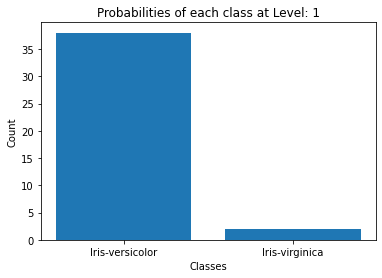

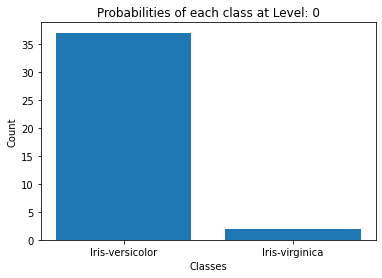

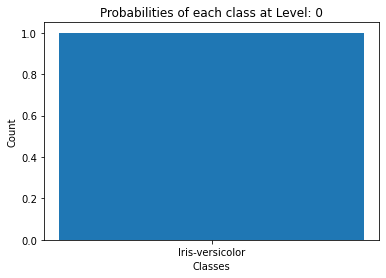

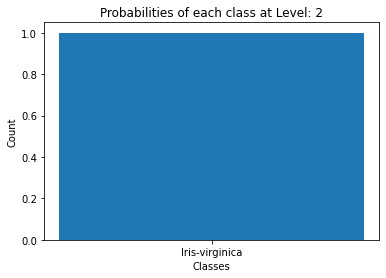

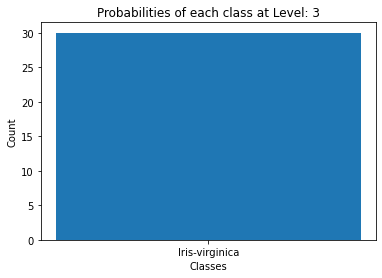

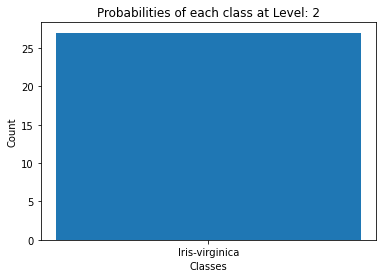

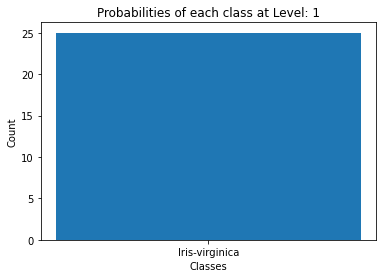

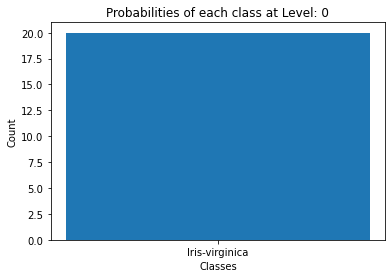

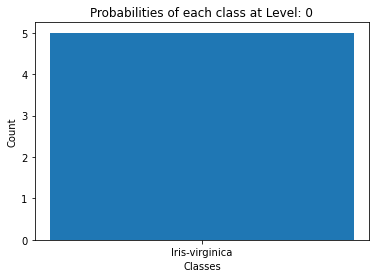

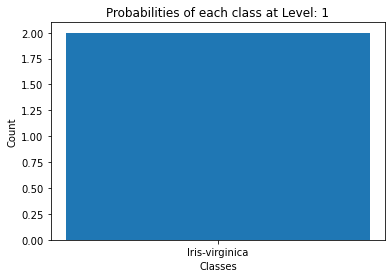

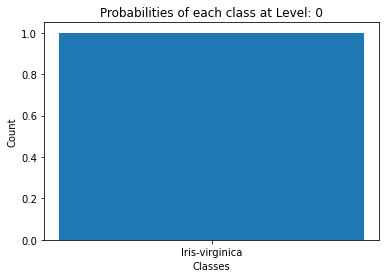

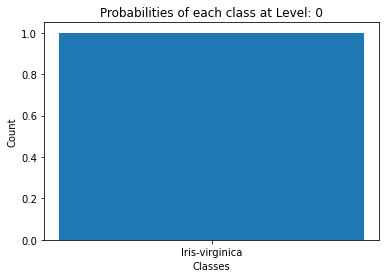

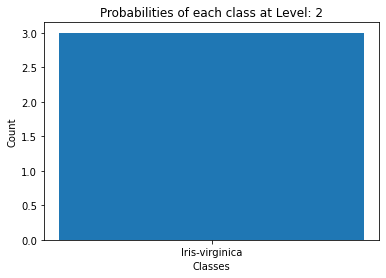

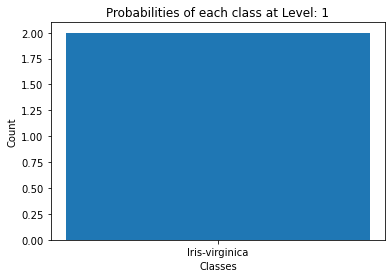

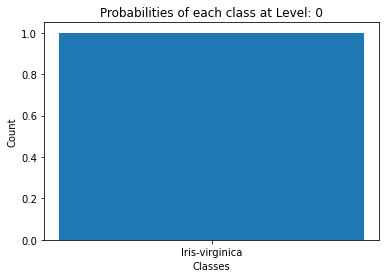

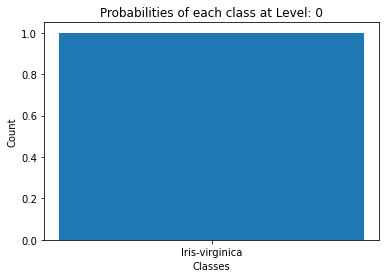

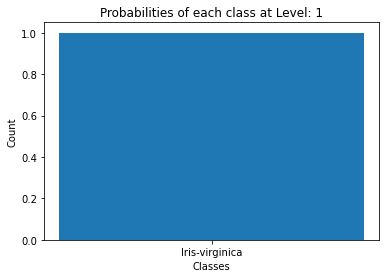

Printing the Tree using a breath first tree traversal:

check for petal_width <= 0.75
True: 
  check for petal_width <= 0.45
  True: 
    check for petal_width <= 0.35
    True: 
      check for petal_width <= 0.25
      True: 
        check for petal_width <= 0.15000000000000002
        True: 
          Leaf Node: Iris-setosa
        False: 
          Leaf Node: Iris-setosa
      False: 
        check for petal_length <= 1.45
        True: 
          Leaf Node: Iris-setosa
        False: 
          Leaf Node: Iris-setosa
    False: 
      check for petal_length <= 1.65
      True: 
        check for petal_length <= 1.4500000000000002
        True: 
          Leaf Node: Iris-setosa
        False: 
          Leaf Node: Iris-setosa
      False: 
        Leaf Node: Iris-setosa
  False: 
    Leaf Node: Iris-setosa
False: 
  check for petal_width <= 1.75
  True: 
    check for petal_length <= 5.35
    True: 
      check for sepal_length <= 4.95
      True: 
        Leaf Node: Iris-virginica

In [ ]:
for max_depth in max_depth_list:
    print('--------------------------------------------------------------\n')
    print('Learning Decision Tree with Misclassification Rate and Max Depth: {}\n'.format(max_depth))
    root = learn_decision_tree(iris_train, iris_headers, 4, 'mcr' , max_depth)
    print('Printing the Tree using a breath first tree traversal:\n')
    print_tree(root)
    print('\nAccuracy: {}\n'.format(accuracy(root, iris_validation, 4)))
    print('Cross Entropy Loss: {}\n'.format(-1 * np.log(accuracy(root, iris_validation, 4))))

#### Part B: Experimenting with other Quality-criterion: Information Gain

##### Applying Grid Search on Max-Depth, Printing the Resultant Tree and Displaying the Accuarcy and Cross Entropy Loss

--------------------------------------------------------------

Learning Decision Tree with Information Gain and Max Depth: 1



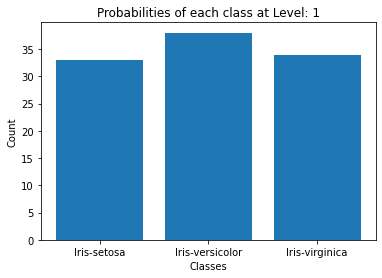

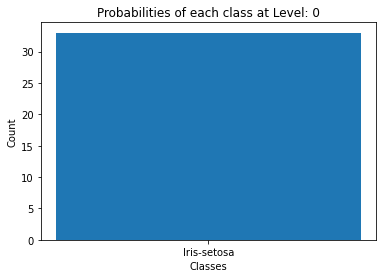

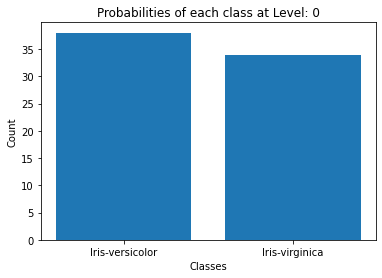

Printing the Tree using a breath first tree traversal:

check for petal_width <= 0.75
True: 
  Leaf Node: Iris-setosa
False: 
  Leaf Node: Iris-versicolor

Accuracy: 0.6363636363636364

Cross Entropy Loss: 0.45198512374305727

--------------------------------------------------------------

Learning Decision Tree with Information Gain and Max Depth: 2



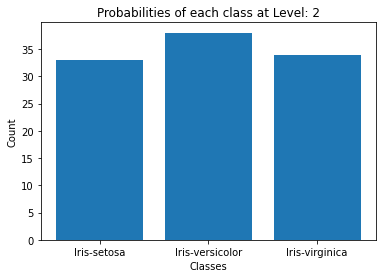

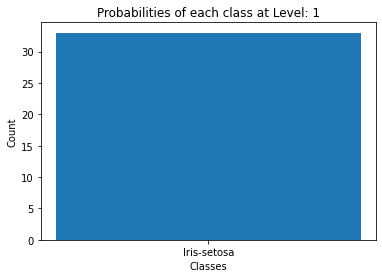

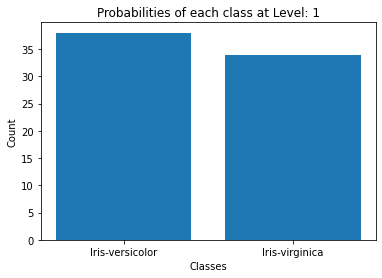

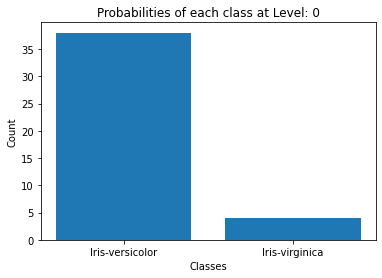

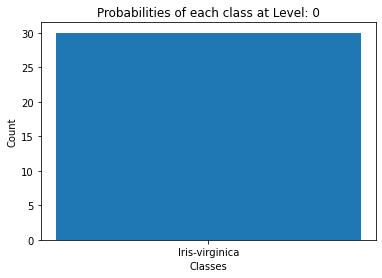

Printing the Tree using a breath first tree traversal:

check for petal_width <= 0.75
True: 
  Leaf Node: Iris-setosa
False: 
  check for petal_width <= 1.75
  True: 
    Leaf Node: Iris-versicolor
  False: 
    Leaf Node: Iris-virginica

Accuracy: 0.9545454545454546

Cross Entropy Loss: 0.04652001563489282

--------------------------------------------------------------

Learning Decision Tree with Information Gain and Max Depth: 3



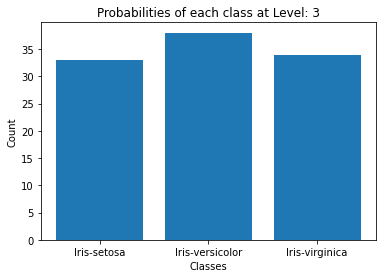

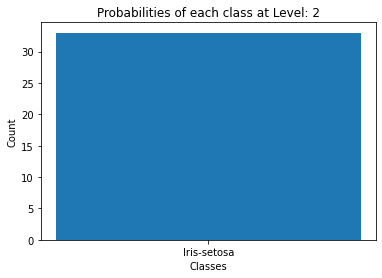

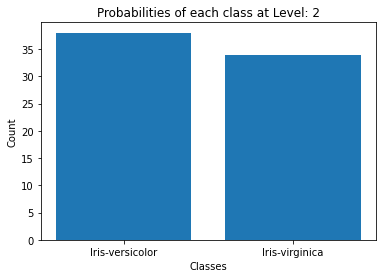

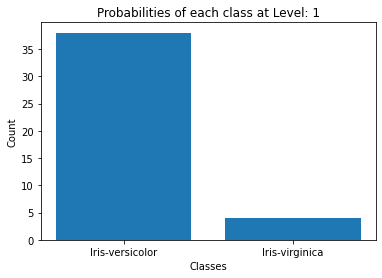

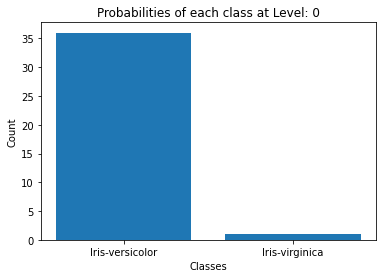

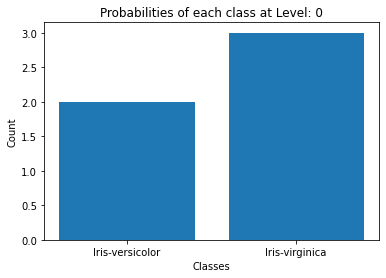

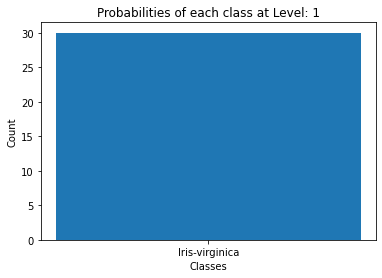

Printing the Tree using a breath first tree traversal:

check for petal_width <= 0.75
True: 
  Leaf Node: Iris-setosa
False: 
  check for petal_width <= 1.75
  True: 
    check for petal_length <= 4.95
    True: 
      Leaf Node: Iris-versicolor
    False: 
      Leaf Node: Iris-virginica
  False: 
    Leaf Node: Iris-virginica

Accuracy: 1.0

Cross Entropy Loss: -0.0

--------------------------------------------------------------

Learning Decision Tree with Information Gain and Max Depth: 4



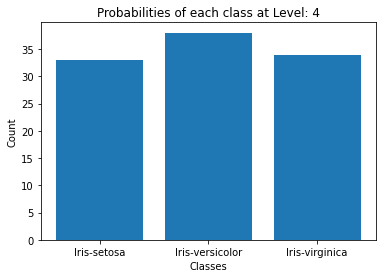

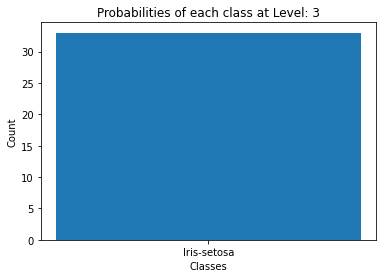

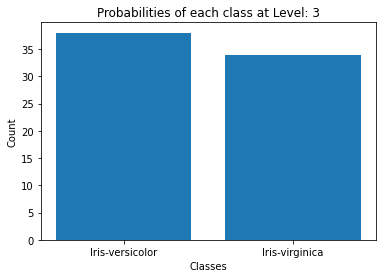

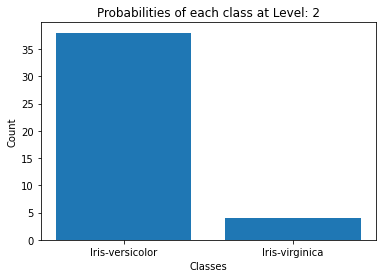

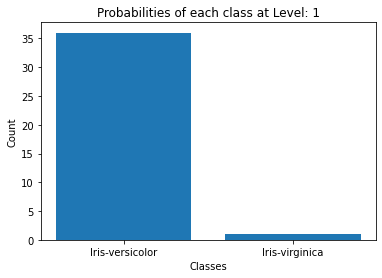

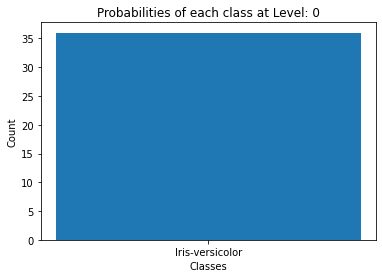

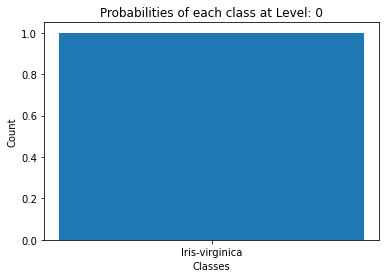

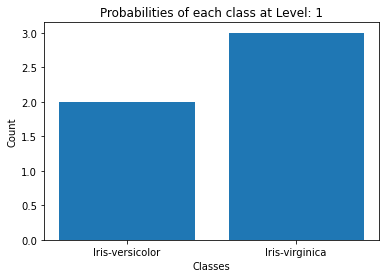

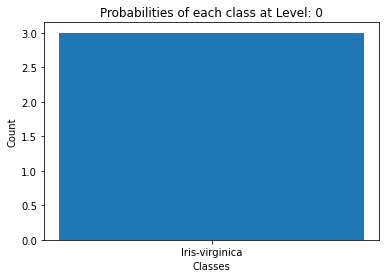

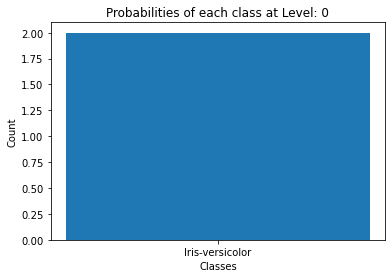

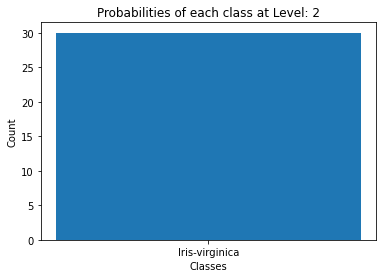

Printing the Tree using a breath first tree traversal:

check for petal_width <= 0.75
True: 
  Leaf Node: Iris-setosa
False: 
  check for petal_width <= 1.75
  True: 
    check for petal_length <= 4.95
    True: 
      check for petal_width <= 1.65
      True: 
        Leaf Node: Iris-versicolor
      False: 
        Leaf Node: Iris-virginica
    False: 
      check for petal_width <= 1.55
      True: 
        Leaf Node: Iris-virginica
      False: 
        Leaf Node: Iris-versicolor
  False: 
    Leaf Node: Iris-virginica

Accuracy: 0.9545454545454546

Cross Entropy Loss: 0.04652001563489282

--------------------------------------------------------------

Learning Decision Tree with Information Gain and Max Depth: 5



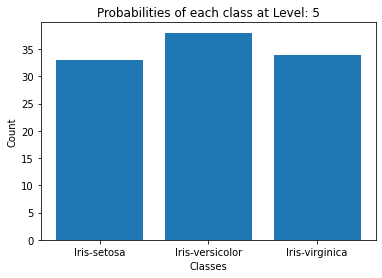

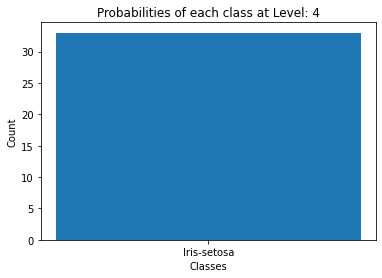

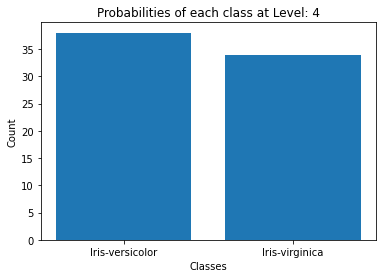

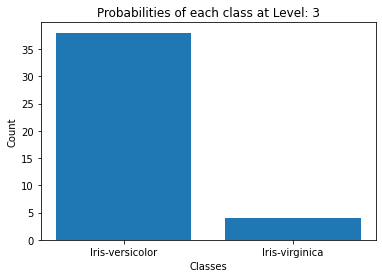

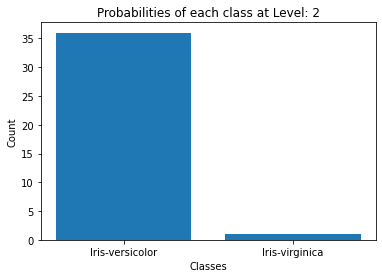

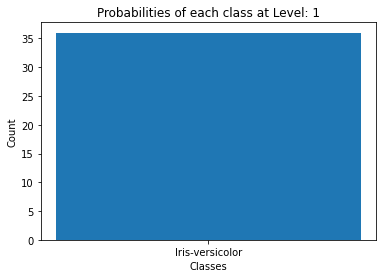

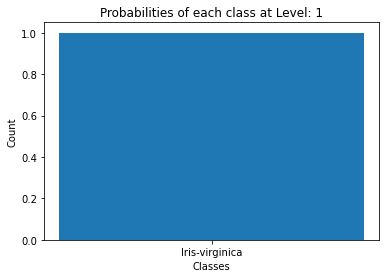

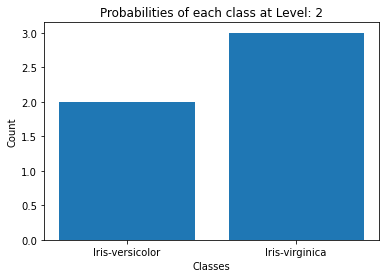

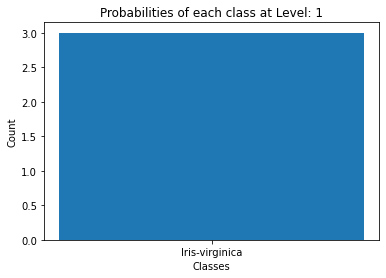

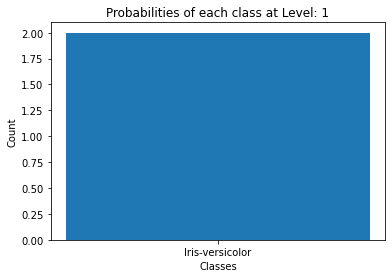

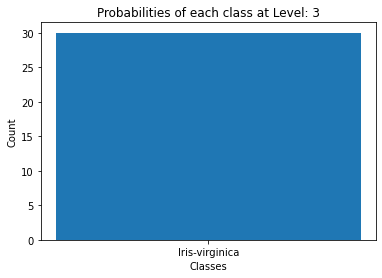

Printing the Tree using a breath first tree traversal:

check for petal_width <= 0.75
True: 
  Leaf Node: Iris-setosa
False: 
  check for petal_width <= 1.75
  True: 
    check for petal_length <= 4.95
    True: 
      check for petal_width <= 1.65
      True: 
        Leaf Node: Iris-versicolor
      False: 
        Leaf Node: Iris-virginica
    False: 
      check for petal_width <= 1.55
      True: 
        Leaf Node: Iris-virginica
      False: 
        Leaf Node: Iris-versicolor
  False: 
    Leaf Node: Iris-virginica

Accuracy: 0.9545454545454546

Cross Entropy Loss: 0.04652001563489282



In [ ]:
for max_depth in max_depth_list:
    print('--------------------------------------------------------------\n')
    print('Learning Decision Tree with Information Gain and Max Depth: {}\n'.format(max_depth))
    root = learn_decision_tree(iris_train, iris_headers, 4, 'gain' , max_depth)
    print('Printing the Tree using a breath first tree traversal:\n')
    print_tree(root)
    print('\nAccuracy: {}\n'.format(accuracy(root, iris_validation, 4)))
    print('Cross Entropy Loss: {}\n'.format(-1 * np.log(accuracy(root, iris_validation, 4))))

### Exercise 2: Gradient Boosted Decision Trees

#### Generating a binary classification toy dataset from the scikit-learn utility "make-moons" with 100 samples and for 10 different levels of noise

In [66]:
#Different Values of noise
noise = np.arange(0.1,0.2,0.01)

#Creating the Binary Classification Dataset
X , y = make_moons(n_samples=100, noise = noise[0])
for n in noise[1:]:
    new_X, new_y = make_moons(n_samples=100, noise=n)
    X = np.append(X, new_X, axis=0)
    y = np.append(y, new_y, axis=0)

#### Visualizing the 100 different pairs of so-called moons

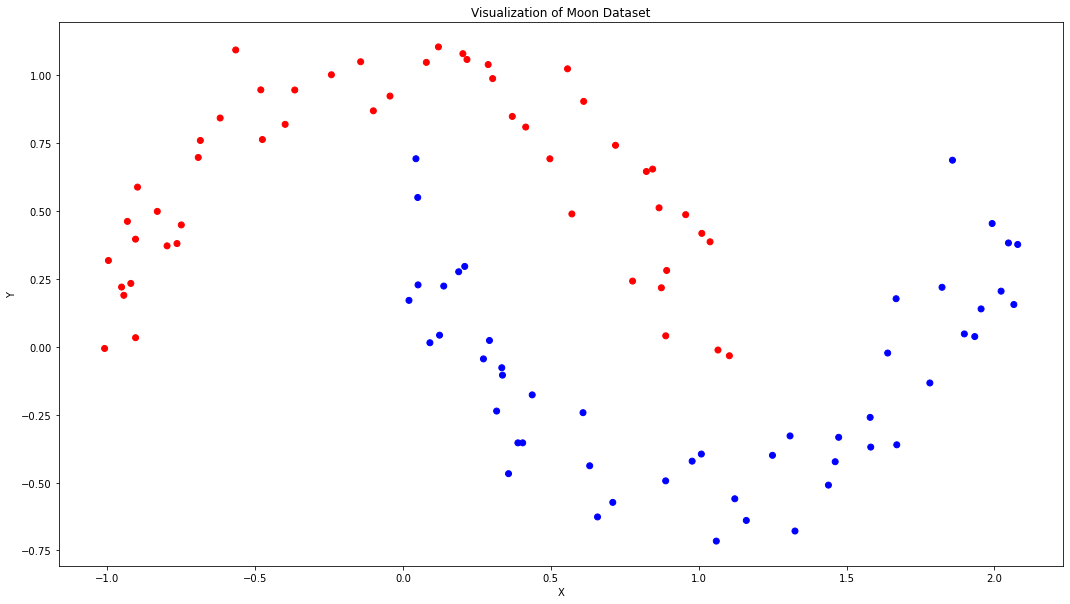

In [67]:
#Creating a vector containing the color for each instance based on its class
vec = np.vectorize(lambda x : 'red' if x == 0 else 'blue')

#Plotting the 100 pairs of Moons
fig = plt.figure(figsize=(18,10))
plt.scatter(X[:100,0],X[:100,1], c = vec(y[:100]))
plt.title('Visualization of Moon Dataset')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

#### Generating train/validation/test splits with the ratios like before

In [68]:
#Converting the Moon dataset into Dataframe for the purpose of Splitting
moon_df = pd.DataFrame.from_dict({'x':X[:,0], 'y':X[:,1], 'class':y})

#Splitting the Dataset
moon_train, moon_validation, moon_test = split_dataset(moon_df)

#### Keeping the max depth of trees to 2 i.e root node then leaf nodes (also called stumps), and tuning the number of trees in the ensemble on the validation set.

##### Function for calculating the Sigmoid of any value

In [69]:
def sigmoid(x):
    #Sigmoid = 1 / (1 + e^-x)
    return 1 / (1 + np.exp(-1 * x))

##### Function to Calculate the L(n) on actual Y and Predicted Y

In [70]:
def LN(actual_y, predicted_y):
    return -1 * actual_y * np.log(predicted_y) - (1 - actual_y) * np.log(1 - sigmoid(predicted_y))

##### Function to Calculate the Gradient on actual Y and Predicted Y

In [71]:
def GN(actual_y, predicted_y):
    return sigmoid(predicted_y) - actual_y

##### Function to Calculate the Hessian on actual Y and Predicted Y

In [72]:
def HN(actual_y, predicted_y):
    return sigmoid(predicted_y) * (1 - sigmoid(predicted_y))

##### Function to Calculate the Gain on the Ensemble Trees

In [73]:
def boosted_gain(dataset, left_dataset, right_dataset, lamda, gn_index, hn_index):
    return 0.5 * ((sum(left_dataset[:,gn_index])/(lamda + sum(left_dataset[:,hn_index]))) + 
                  (sum(right_dataset[:,gn_index])/(lamda + sum(right_dataset[:,hn_index]))) - 
                  (sum(dataset[:,gn_index])/(lamda + sum(dataset[:,hn_index]))))

##### Function to find the Best split based on Ensemble Gain value

In [74]:
def best_fit_boosted_gain(dataset, headers, target_column, lamda, gn_index, hn_index):
    #Initializing the best Enemble Gain to 0 and best Condition to None
    best_gain = 0
    best_question = None
    
    #Iterating through all feature columns
    for i in range(len(dataset[0])):
        #We have to skip the class column
        if i == target_column:
            continue
        
        #Extracting the unique values from the selected column
        unique_values = np.unique(dataset[:,i])
        
        #If the column values are numeric than calculating the list containing the average values between two consecutive numbers
        if isinstance(unique_values[0], int) or isinstance(unique_values[0], float):
            unique_values = numerical_splitting_average(unique_values)
        
        #Iterating through all unique values
        for unique_val in unique_values:
            
            #Creating a condition with selected feature and unique value
            question = Question(headers[i], i, unique_val)
            
            #Calculating the Information Gain value for that condition
            left_data , right_data = question.apply_split(dataset)
            gain = boosted_gain(dataset, left_data, right_data, lamda, gn_index, hn_index)
            
            #If we find a better Information Gain then swapping it with the previous best
            if gain >= best_gain:
                best_gain = gain
                best_question = question
    
    #Returning the Best Information Gain and Best Condition          
    return best_gain, best_question

##### Function to Learn a Gradient Boosted Decision Tree from the Dataset

In [75]:
def learn_gradient_boosted_decision_tree(dataset, headers, target_column, lamda, gn_index, hn_index, max_depth = 2):
    
    #Calculating the Best Condition based on Either MCR or Information Gain
    eval_val , question = best_fit_boosted_gain(dataset, headers, target_column, lamda, gn_index, hn_index)
    
    #If max depth is achieved than return from Recursion
    if max_depth == 0:
        #Extracting the Dominant Class
        unique_values, counts = np.unique(dataset[:,target_column], return_counts=True)
        dominant_class = unique_values[np.argmax(counts)]
        
        #Returning the Node
        return Node(question, None, None, True, dominant_class)
    
    #If Ensemble Gain is 0 or the Question is Null, then it is Leaf node
    if eval_val == 0 or question == None:
        #Extracting the Dominant Class
        unique_values, counts = np.unique(dataset[:,target_column], return_counts=True)
        dominant_class = unique_values[np.argmax(counts)]
        
        #Returning the Leaf Node
        return Node(question, None, None, True, dominant_class)
    
    #Split the Data into Left and Right Dataset based on Best Condition
    left_data, right_data = question.apply_split(dataset)
    
    #Creating a Left Child Node using Recursive call
    left_node = learn_gradient_boosted_decision_tree(left_data, headers, target_column, lamda, gn_index, hn_index, max_depth - 1)
    
    #Creating a Right Child Node using Recursive call
    right_node = learn_gradient_boosted_decision_tree(right_data, headers, target_column, lamda, gn_index, hn_index, max_depth - 1)
    
    #Returning the Node which is not Leaf and contains Left and Right Nodes
    return Node(question, left_node, right_node, False, '')

##### Function to update the values of Gradients and Hessians of each instances in the Dataset

In [76]:
def update_gradient_hessians(dataset, actual_y_index, predicted_y_index, sig_index, gn_index, hn_index):
    #Iterating over all rows
    for index, row in enumerate(dataset):
        #Calculating the Sigmoid of predicted value
        dataset[index,sig_index] = sigmoid(dataset[index,predicted_y_index])
        
        #Calculating the Gradient from the actual and predicted value
        dataset[index,gn_index] = GN(dataset[index,actual_y_index],dataset[index,predicted_y_index])
        
        #Calculating the Hessian from the actual and predicted value
        dataset[index,hn_index] = HN(dataset[index,actual_y_index],dataset[index,predicted_y_index])
        
    #Returning the Dataset
    return dataset

##### Function to apply different Number of Gradient Boosted Decision Trees and Calculating there Accuracies

In [77]:
total_ensemble_trees = 3

In [78]:
def create_ensemble_trees(train_dataset,validation_dataset,test_dataset, headers, target_column, lamda):
    
    #Appending new Columns in the Training dataset for Gradient, Hessians etc.
    #Here:
    #Column Index 2 denotes: Actual Y
    #Column Index 3 denotes: Predicted Y
    #Column Index 4 denotes: Sigmoid of Predicted Y
    #Column Index 5 denotes: Gradient
    #Column Index 6 denotes: Hessian
    train_dataset = np.append(train_dataset, np.zeros(shape=(len(train_dataset),4)), axis=1)
    
    #Appending only Predicted Y column in the Validation Dataset
    validation_dataset = np.append(validation_dataset, np.zeros(shape=(len(validation_dataset),1)), axis=1)
    
    #Appending only Predicted Y column in the Test Dataset
    test_dataset = np.append(test_dataset, np.zeros(shape=(len(test_dataset),1)), axis=1)
    
    #Updating the values of Gradient and Hessians for each instance in the Training dataset
    train_dataset = update_gradient_hessians(train_dataset, 2,3,4,5,6)
    
    #List for storing different trees
    trees = []
    
    #Iterating over different number of Trees in an Ensemble
    for i in range(1,total_ensemble_trees+1):
        
        print('---------------------------------------------------------------------')
        print('Creating a Ensemble with {} Trees'.format(i))
        print('---------------------------------------------------------------------')
        
        #Iterating for creating specified number of Trees in the Ensemble
        for j in range(i):
            
            print('\nTree {}:'.format(j+1))
            
            #Creating a Tree 
            root = learn_gradient_boosted_decision_tree(train_dataset, headers, target_column, lamda, 5, 6, max_depth = 2)
            
            #Calculating the Predicted Y and storing it into the Dataset
            for index, row in enumerate(train_dataset):
                train_dataset[index,3] = train_dataset[index,3] + (lamda * predict_class(root, row))
            
            #Updating the Gradients and Hessians for the next Iteration
            train_dataset = update_gradient_hessians(train_dataset, 2,3,4,5,6)
            
            #Appending the new Created Tree into the list
            trees.append(root)
            
            #Printing the Tree
            print_tree(root)
        
        #Iterating over all Trees with Validation Dataset
        for j in range(i):
            
            #Extracting the current Tree
            current_tree = trees[j]
            
            #Calculating the Predicted Y for the Validation Dataset
            for index, row in enumerate(validation_dataset):
                validation_dataset[index,3] = validation_dataset[index,3] + (lamda * predict_class(current_tree, row))
        
        #Mapping each Predicted Y values in the Validation dataset with the Sigmoid Activation function
        validation_dataset[:,3] = list(map(lambda x : 0 if sigmoid(x) <= 0.5 else 1, validation_dataset[:,3]))
        
        #Calculating the Total Accuracy of the current Number of Trees in the Ensemble
        correct_prediction = 0
        
        #Foreach validation row checking if the predicted Class is equal to Actual Class
        for row in validation_dataset:
            if row[2] == row[3]:
                correct_prediction += 1
        
        #Printing the Accuracy of the current Number of Trees in the Ensemble
        print('\nAccuracy of Validation with Total Ensemble Trees: {} is: {}\n'.format(i, correct_prediction/len(validation_dataset)))
        
        #Iterating over all Trees with Test Dataset
        for j in range(i):
            
            #Extracting the current Tree
            current_tree = trees[j]
            
            #Calculating the Predicted Y for the Test Dataset
            for index, row in enumerate(test_dataset):
                test_dataset[index,3] = test_dataset[index,3] + (lamda * predict_class(current_tree, row))
        
        #Mapping each Predicted Y values in the Validation dataset with the Sigmoid Activation function
        test_dataset[:,3] = list(map(lambda x : 0 if sigmoid(x) <= 0.5 else 1, test_dataset[:,3]))
        
        #Calculating the Total Accuracy of the current Number of Trees in the Ensemble
        correct_prediction = 0
        
        #Foreach validation row checking if the predicted Class is equal to Actual Class
        for row in test_dataset:
            if row[2] == row[3]:
                correct_prediction += 1
        
        #Printing the Accuracy of the current Number of Trees in the Ensemble
        print('\nAccuracy of Test with Total Ensemble Trees: {} is: {}\n'.format(i, correct_prediction/len(test_dataset)))
        
        #Emptying list for next iteration
        trees = []
        
        #Renewing Columns in the Training dataset for Gradient, Hessians etc.
        train_dataset = np.append(train_dataset, np.zeros(shape=(len(train_dataset),4)), axis=1)
    
        #Renewing Predicted Y column in the Validation Dataset
        validation_dataset = np.append(validation_dataset, np.zeros(shape=(len(validation_dataset),1)), axis=1)
        
        #Appending only Predicted Y column in the Test Dataset
        test_dataset = np.append(test_dataset, np.zeros(shape=(len(test_dataset),1)), axis=1)

        #Renewing the values of Gradient and Hessians for each instance in the Training dataset
        train_dataset = update_gradient_hessians(train_dataset, 2,3,4,5,6)

##### Creating different Ensembles with different Number of Trees

In [80]:
create_ensemble_trees(moon_train, moon_validation,moon_test, ['X','Y','Class','Predicted_class', 'Sigmoid', 'GN', 'HN'], 2, 0.1)

---------------------------------------------------------------------
Creating a Ensemble with 1 Trees
---------------------------------------------------------------------

Tree 1:
check for Y <= 1.1128462219796047
True: 
  check for Y <= 1.0533527269806844
  True: 
    Leaf Node: 1.0
  False: 
    Leaf Node: 0.0
False: 
  check for Y <= 1.1682457059718352
  True: 
    Leaf Node: 0.0
  False: 
    Leaf Node: 0.0

Accuracy of Validation with Total Ensemble Trees: 1 is: 0.52


Accuracy of Test with Total Ensemble Trees: 1 is: 0.5066666666666667

---------------------------------------------------------------------
Creating a Ensemble with 2 Trees
---------------------------------------------------------------------

Tree 1:
check for X <= -1.069998683844033
True: 
  check for Y <= 0.20836093309419113
  True: 
    Leaf Node: 0.0
  False: 
    Leaf Node: 0.0
False: 
  check for X <= -0.9555080724324898
  True: 
    Leaf Node: 0.0
  False: 
    Leaf Node: 1.0

Tree 2:
check for Y <= 1.1128